In [1]:
#https://ieeexplore.ieee.org/document/10549889

In [2]:
!pip install openpyxl ssqueezepy

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.2/127.2 kB 11.9 MB/s eta 0:00:00


In [3]:
# !pip install --upgrade tensorflow

In [63]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, Sequential
from tensorflow.keras.applications import ResNet50
from ssqueezepy import cwt
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt
import pywt
import matplotlib.pyplot as plt
from tensorflow.keras.layers import MaxPooling1D

In [5]:
import keras.models
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

In [6]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values



# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + 'UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + 'UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1

    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [7]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [8]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
Y train One hot shape:  (7352, 6)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)
Y test One hot shape:  (2947, 6)


In [9]:
print("0: Walking:" ,np.where(trainy == 0)[0].size)
print("1: WU:" ,np.where(trainy == 1)[0].size)
print("2: WD:" ,np.where(trainy == 2)[0].size)
print("3: Sitting:" ,np.where(trainy == 3)[0].size)
print("4: Standing:" ,np.where(trainy == 4)[0].size)
print("5: Laying:" ,np.where(trainy == 5)[0].size)

0: Walking: 1226
1: WU: 1073
2: WD: 986
3: Sitting: 1286
4: Standing: 1374
5: Laying: 1407


In [10]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   0 1226]
 [   1 1073]
 [   2  986]
 [   3 1286]
 [   4 1374]
 [   5 1407]]
Test data label statistics::
[[  0 496]
 [  1 471]
 [  2 420]
 [  3 491]
 [  4 532]
 [  5 537]]


In [11]:
# from sklearn.preprocessing import StandardScaler

# def scale_data(trainX, testX):
#  # remove overlap
#  cut = int(trainX.shape[1] / 2)
#  longX = trainX[:, -cut:, :]
#  # flatten windows
#  longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
#  # flatten train and test
#  flatTrainX = trainX.reshape((trainX.shape[0] * trainX.shape[1], trainX.shape[2]))
#  flatTestX = testX.reshape((testX.shape[0] * testX.shape[1], testX.shape[2]))

#  s = StandardScaler()
#  # fit on training data
#  s.fit(longX)
#  # apply to training and test data
#  longX = s.transform(longX)
#  flatTrainX = s.transform(flatTrainX)
#  flatTestX = s.transform(flatTestX)
#  # reshape
#  flatTrainX = flatTrainX.reshape((trainX.shape))
#  flatTestX = flatTestX.reshape((testX.shape))
#  return flatTrainX, flatTestX

In [12]:
# trainX, testX = scale_data(trainX, testX)

In [13]:
X_train_all = trainX   # at this stage, the data includes both dynamic and static HAR data
y_train_all = trainy

X_test_all = testX
y_test_all = testy

In [14]:
import random

static_1 = np.where(trainy == 3)[0]
static_2 = np.where(trainy == 4)[0]
static_3 = np.where(trainy == 5)[0]
static = np.concatenate([static_1, static_2, static_3])
static_list = static.tolist()

# Shuffle dynamic data index
r = random.random()
random.shuffle(static_list, lambda: r)

static = np.array(static)

trainX = X_train_all[static]
trainy = y_train_all[static]

/tmp/ipykernel_115/2481253413.py:11: DeprecationWarning: The *random* parameter to shuffle() has been deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.shuffle(static_list, lambda: r)


In [15]:
static_1 = np.where(testy == 3)[0]
static_2 = np.where(testy == 4)[0]
static_3 = np.where(testy == 5)[0]
static = np.concatenate([static_1, static_2, static_3])
static_list = static.tolist()

r = random.random()
random.shuffle(static_list, lambda: r)

static = np.array(static_list)

testX = X_test_all[static]
testy = y_test_all[static]

/tmp/ipykernel_115/4217821953.py:8: DeprecationWarning: The *random* parameter to shuffle() has been deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.shuffle(static_list, lambda: r)


In [16]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   3 1286]
 [   4 1374]
 [   5 1407]]
Test data label statistics::
[[  3 491]
 [  4 532]
 [  5 537]]


In [17]:
trainy = trainy - 3
testy = testy - 3

In [18]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# 기존 차원
print("X_train shape:", trainX.shape)
print("X_test:", testX.shape)


# MinMaxScaler 초기화
scaler = MinMaxScaler(feature_range=(0, 1))

# 데이터 Reshape (2D로 변환)
X_train_reshaped = trainX.reshape(-1, trainX.shape[-1])  # (4067*128, 9)
X_test_reshaped = testX.reshape(-1, testX.shape[-1])    # (1560*128, 9)

# MinMaxScaler 적용
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)

# 원래 차원으로 복원
trainX = X_train_scaled.reshape(trainX.shape)  # (4067, 128, 9)
testX = X_test_scaled.reshape(testX.shape)     # (1560, 128, 9)

# 결과 확인
print("X_train_normalized shape:", trainX.shape)
print("X_test_normalized shape:", testX.shape)

X_train shape: (4067, 128, 9)
X_test: (1560, 128, 9)
X_train_normalized shape: (4067, 128, 9)
X_test_normalized shape: (1560, 128, 9)


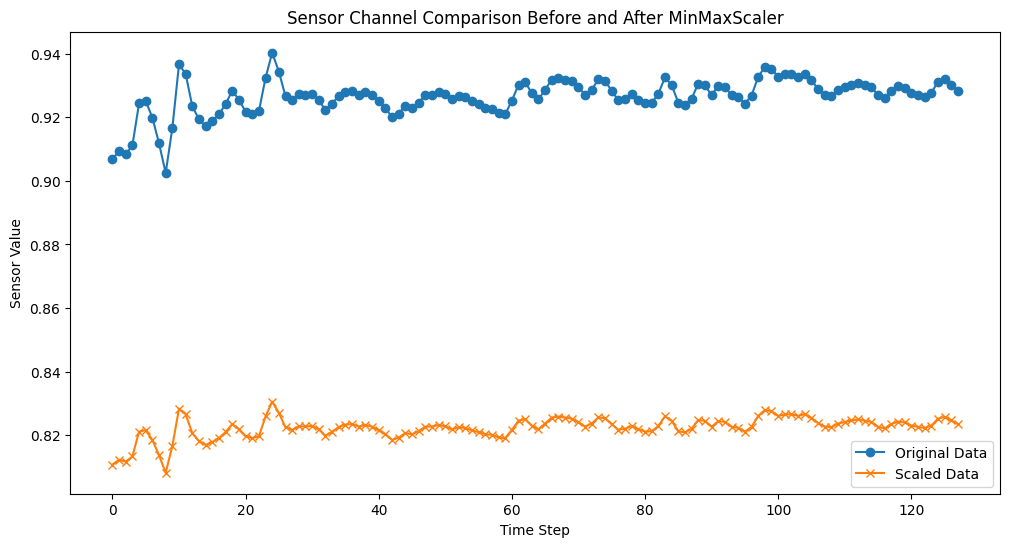

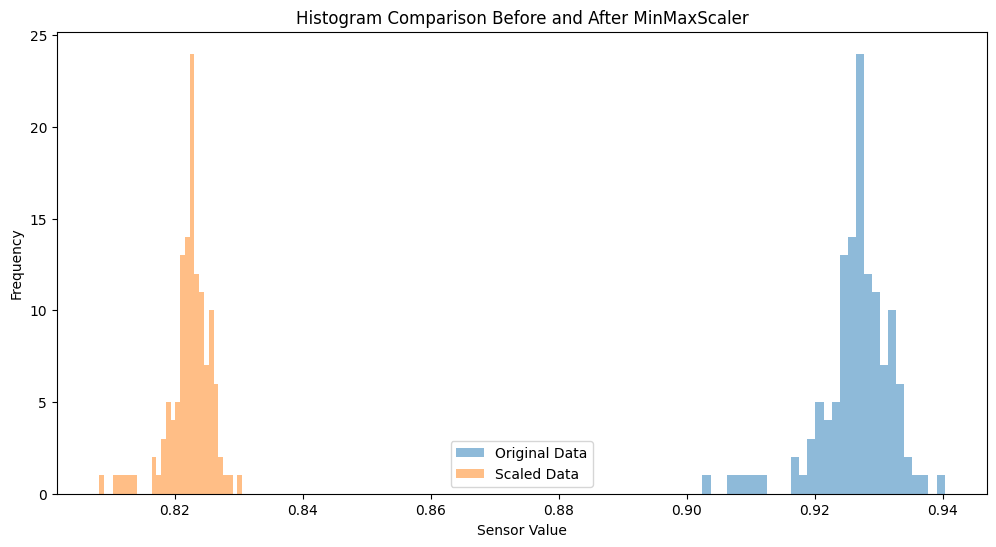

In [19]:
import matplotlib.pyplot as plt

# 첫 번째 샘플의 첫 번째 센서 채널 선택
sample_idx = 0
sensor_channel = 0

# 스케일링 전 데이터
original_sample = X_train_reshaped[:128, sensor_channel]  # 첫 번째 샘플 128 timestep
scaled_sample = X_train_scaled[:128, sensor_channel]

# 시계열 그래프 비교
plt.figure(figsize=(12, 6))
plt.plot(original_sample, label='Original Data', marker='o')
plt.plot(scaled_sample, label='Scaled Data', marker='x')
plt.title('Sensor Channel Comparison Before and After MinMaxScaler')
plt.xlabel('Time Step')
plt.ylabel('Sensor Value')
plt.legend()
plt.show()

# 히스토그램 비교
plt.figure(figsize=(12, 6))
plt.hist(original_sample, bins=30, alpha=0.5, label='Original Data')
plt.hist(scaled_sample, bins=30, alpha=0.5, label='Scaled Data')
plt.title('Histogram Comparison Before and After MinMaxScaler')
plt.xlabel('Sensor Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [42]:
# import numpy as np
# from collections import Counter

# def split_sequence_with_sliding_window(X, Y, n_steps, step_size):
#     """
#     Apply sliding window to split X and Y into sequences of length n_steps
#     Args:
#         X (numpy array): Feature data of shape (samples, timesteps, features)
#         Y (numpy array): Labels of shape (samples, 1)
#         n_steps (int): Length of each sequence
#         step_size (int): Step size for sliding window
#     Returns:
#         X_out (numpy array): Split feature data
#         Y_out (numpy array): Split labels
#     """
#     X_out, Y_out = [], []
#     for i in range(0, X.shape[0] - n_steps + 1, step_size):
#         # Create window
#         seq_x = X[i:i + n_steps]
#         seq_y = Y[i:i + n_steps]
        
#         # Choose the most common label in the window
#         most_common_label = Counter(seq_y.flatten()).most_common(1)[0][0]
        
#         X_out.append(seq_x)
#         Y_out.append(most_common_label)
    
#     return np.array(X_out), np.array(Y_out)

In [43]:
# # Parameters
# n_steps = 128  # Window size
# step_size = 64  # 50% overlap

# # Apply sliding window
# trainX, trainy = split_sequence_with_sliding_window(trainX, trainy, n_steps, step_size)
# testX, testy = split_sequence_with_sliding_window(testX, testy, n_steps, step_size)

# # Output shapes
# print("X_train_aug shape:", trainX.shape)
# print("Y_train_aug shape:", trainy.shape)
# print("X_test_aug shape:", testX.shape)
# print("Y_test_aug shape:", testy.shape)


X_train_aug shape: (62, 128, 128, 9)
Y_train_aug shape: (62,)
X_test_aug shape: (23, 128, 128, 9)
Y_test_aug shape: (23,)


In [20]:
trainy_one_hot = to_categorical(trainy)
testy_one_hot = to_categorical(testy)

In [21]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (4067, 128, 9)
Y train shape:  (4067, 1)
Y train One hot shape:  (4067, 3)
X test shape:  (1560, 128, 9)
Y test shape:  (1560, 1)
Y test One hot shape:  (1560, 3)


In [22]:
n_classes = 3

In [23]:
print(trainX.shape)
print(trainy_one_hot.shape)

(4067, 128, 9)
(4067, 3)


In [24]:
# def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.3):
#     x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
#     x = layers.Dropout(dropout)(x)
#     x = layers.LayerNormalization(epsilon=1e-6)(x)
#     res = x + inputs

#     x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
#     x = layers.Dropout(dropout)(x)
#     x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
#     x = layers.LayerNormalization(epsilon=1e-6)(x)
#     return x + res

In [25]:
# def build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0.3):
#     inputs = Input(shape=input_shape, name="Transformer_Input")
#     x = inputs
#     for _ in range(num_transformer_blocks):
#         x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
#     x = layers.GlobalAveragePooling1D()(x)
#     for dim in mlp_units:
#         x = layers.Dense(dim, activation="relu")(x)
#         x = layers.Dropout(dropout)(x)
#     return inputs, x

In [26]:
# def resnet_block(inputs, filters, kernel_size=3, strides=1):
#     x = layers.Conv1D(filters, kernel_size=kernel_size, strides=strides, padding='same')(inputs)
#     x = layers.BatchNormalization()(x)
#     x = layers.ReLU()(x)

#     x = layers.Conv1D(filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
#     x = layers.BatchNormalization()(x)

#     shortcut = layers.Conv1D(filters, kernel_size=1, strides=strides, padding='same')(inputs)
#     shortcut = layers.BatchNormalization()(shortcut)

#     x = layers.Add()([x, shortcut])
#     x = layers.ReLU()(x)
#     return x

In [27]:
# def build_resnet_model(input_shape):
#     inputs = Input(shape=input_shape, name="ResNet_Input")
#     x = resnet_block(inputs, filters=64)
#     x = resnet_block(x, filters=128)
#     x = layers.GlobalAveragePooling1D()(x)
#     x = layers.Dense(64, activation="relu")(x)
#     return inputs, x

In [60]:
class GeneralizedMeanPooling1D(layers.Layer):
    def __init__(self, init_norm=3.0, normalize=False, epsilon=1e-6, **kwargs):
        self.init_norm = init_norm
        self.normalize = normalize
        self.epsilon = epsilon
        super(GeneralizedMeanPooling1D, self).__init__(**kwargs)

    def build(self, input_shape):
        self.p = self.add_weight(
            name="norms", 
            shape=(input_shape[-1],),
            initializer=tf.keras.initializers.constant(self.init_norm),
            trainable=True
        )
        super(GeneralizedMeanPooling1D, self).build(input_shape)

    def call(self, inputs):
        x = tf.abs(tf.maximum(self.epsilon, inputs))
        x = tf.pow(x, self.p)
        x = tf.reduce_mean(x, axis=1, keepdims=False)  # Time axis 평균
        x = tf.pow(x, (1.0 / self.p))
        if self.normalize:
            x = tf.nn.l2_normalize(x, axis=1)
        return x

In [68]:
from tensorflow.keras.layers import Conv1D, BatchNormalization, ReLU, Add, GlobalAveragePooling1D, Dense, Input, MaxPooling1D

def residual_block_1d(x, filters, kernel_size, stride=1):
    shortcut = x
    
    # 첫 번째 Conv1D
    x = Conv1D(filters, kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    # 두 번째 Conv1D
    x = Conv1D(filters, kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    
    # 스킵 연결
    if shortcut.shape[-1] != filters:
        shortcut = Conv1D(filters, 1, strides=stride, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)
    
    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

def build_resnet1d_branch(input_shape):
    inputs = Input(shape=input_shape, name="ResNet1D_Input")
    x = Conv1D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling1D(pool_size=3, strides=2, padding='same')(x)
    
    # Residual Blocks
    x = residual_block_1d(x, filters=64, kernel_size=3)
    x = residual_block_1d(x, filters=128, kernel_size=3, stride=2)
    x = residual_block_1d(x, filters=256, kernel_size=3, stride=2)
    x = residual_block_1d(x, filters=512, kernel_size=3, stride=2)
    
    x = GlobalAveragePooling1D()(x)
    x = Dense(1024, activation='relu')(x)
    return inputs, Model(inputs, x, name="ResNet1D_Branch")


In [69]:
from tensorflow.keras import layers, Model, Input
import tensorflow as tf

# Transformer Encoder Block 정의
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    """
    Transformer Encoder Block
    - Multi-Head Self Attention
    - Feed Forward Network (FFN)
    - Dropout
    - Layer Normalization
    
    Args:
        inputs: 입력 텐서
        head_size: Attention head의 차원
        num_heads: Attention head 개수
        ff_dim: Feed Forward Network의 차원
        dropout: 드롭아웃 비율
    
    Returns:
        Transformer Encoder의 출력 텐서
    """
    # Multi-Head Self Attention
    x = layers.MultiHeadAttention(
        key_dim=head_size, 
        num_heads=num_heads, 
        dropout=dropout
    )(inputs, inputs)
    
    # Dropout & Residual Connection
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x + inputs)  # Residual Connection
    
    # Feed Forward Network (FFN)
    ffn = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    ffn = layers.Dropout(dropout)(ffn)
    ffn = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(ffn)
    
    # Dropout & Residual Connection
    x = layers.Dropout(dropout)(ffn)
    x = layers.LayerNormalization(epsilon=1e-6)(x + ffn)
    
    return x

In [70]:
def build_transformer_branch(input_shape):
    """
    Transformer Branch를 생성합니다.
    
    Args:
        input_shape: 입력 데이터의 형태 (timesteps, features)
        
    Returns:
        입력 텐서, Transformer Branch 모델
    """
    # 입력 레이어
    inputs = Input(shape=input_shape, name="Transformer_Input")
    
    # Transformer Encoder Blocks
    x = inputs
    for _ in range(2):  # 2개의 Transformer Encoder Block 사용
        x = transformer_encoder(
            x, 
            head_size=64, 
            num_heads=4, 
            ff_dim=128, 
            dropout=0.3
        )
    
    # Global Average Pooling
    x = layers.GlobalAveragePooling1D()(x)
    
    # Dense Layer (Feature Dimension 확장)
    x = layers.Dense(1024, activation='relu')(x)
    
    return inputs, Model(inputs, x, name="Transformer_Branch")


In [77]:
class OrthogonalFusion(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(name='OrthogonalFusion', **kwargs)

    def call(self, inputs):
        """
        Orthogonal Fusion Layer
        Args:
            inputs: [local_features, global_features]
                - local_features: ResNet1D에서 나온 벡터 (batch_size, 1024)
                - global_features: Transformer에서 나온 벡터 (batch_size, 1024)
        
        Returns:
            orthogonally fused tensor
        """
        local_feat, global_feat = inputs
        
        # 차원 확장
        local_feat = tf.expand_dims(local_feat, axis=1)  # (batch_size, 1, 1024)
        global_feat = tf.expand_dims(global_feat, axis=1)  # (batch_size, 1, 1024)
        
        # Global Feature를 Local Feature와 동일한 형태로 브로드캐스팅
        global_feat = tf.tile(global_feat, [1, tf.shape(local_feat)[1], 1])  # (batch_size, 1, 1024)
        
        # 직교 투영
        projection = tf.reduce_sum(local_feat * global_feat, axis=-1, keepdims=True)  # (batch_size, 1, 1)
        projection = projection * global_feat  # (batch_size, 1, 1024)
        
        # 직교 성분 계산
        orthogonal_comp = local_feat - projection  # (batch_size, 1, 1024)
        
        # 두 특징 결합
        fused_features = tf.concat([global_feat, orthogonal_comp], axis=-1)  # (batch_size, 1, 2048)
        
        # Global Average Pooling
        fused_features = tf.reduce_mean(fused_features, axis=1)  # (batch_size, 2048)
        
        return fused_features


In [78]:
class DOLGNet(Model):
    def __init__(self, input_shape, num_classes=3):
        super(DOLGNet, self).__init__(name='DOLGNet')
        
        # Transformer Branch
        self.transformer_input, self.transformer_branch = build_transformer_branch(input_shape)
        
        # ResNet 1D Branch
        self.resnet_input, self.resnet_branch = build_resnet1d_branch(input_shape)
        
        # Fusion
        self.orthogonal_fusion = OrthogonalFusion()
        
        # Classification Head
        self.head = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        transformer_input, resnet_input = inputs
        
        # Transformer Features
        transformer_output = self.transformer_branch(transformer_input)  # (batch_size, 1024)
        
        # ResNet1D Features
        resnet_output = self.resnet_branch(resnet_input)  # (batch_size, 1024)
        
        # Fusion
        fused_features = self.orthogonal_fusion([resnet_output, transformer_output])  # (batch_size, 2048)
        
        # Classification
        output = self.head(fused_features)
        return output
    
    def build_graph(self):
        transformer_input = tf.keras.Input(shape=(128, 9), name="Transformer_Input")
        resnet_input = tf.keras.Input(shape=(128, 9), name="ResNet1D_Input")
        return Model(inputs=[transformer_input, resnet_input], outputs=self.call([transformer_input, resnet_input]))


In [79]:
# 데이터셋 준비
train_transformer_input = trainX
train_resnet_input = trainX

test_transformer_input = testX
test_resnet_input = testX

# 모델 생성
model = DOLGNet(input_shape=(128, 9), num_classes=3)
model = model.build_graph()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 ResNet1D_Input (InputLayer  [(None, 128, 9)]             0         []                            
 )                                                                                                
                                                                                                  
 Transformer_Input (InputLa  [(None, 128, 9)]             0         []                            
 yer)                                                                                             
                                                                                                  
 ResNet1D_Branch (Functiona  (None, 1024)                 2288640   ['ResNet1D_Input[0][0]']      
 l)                                                                                         

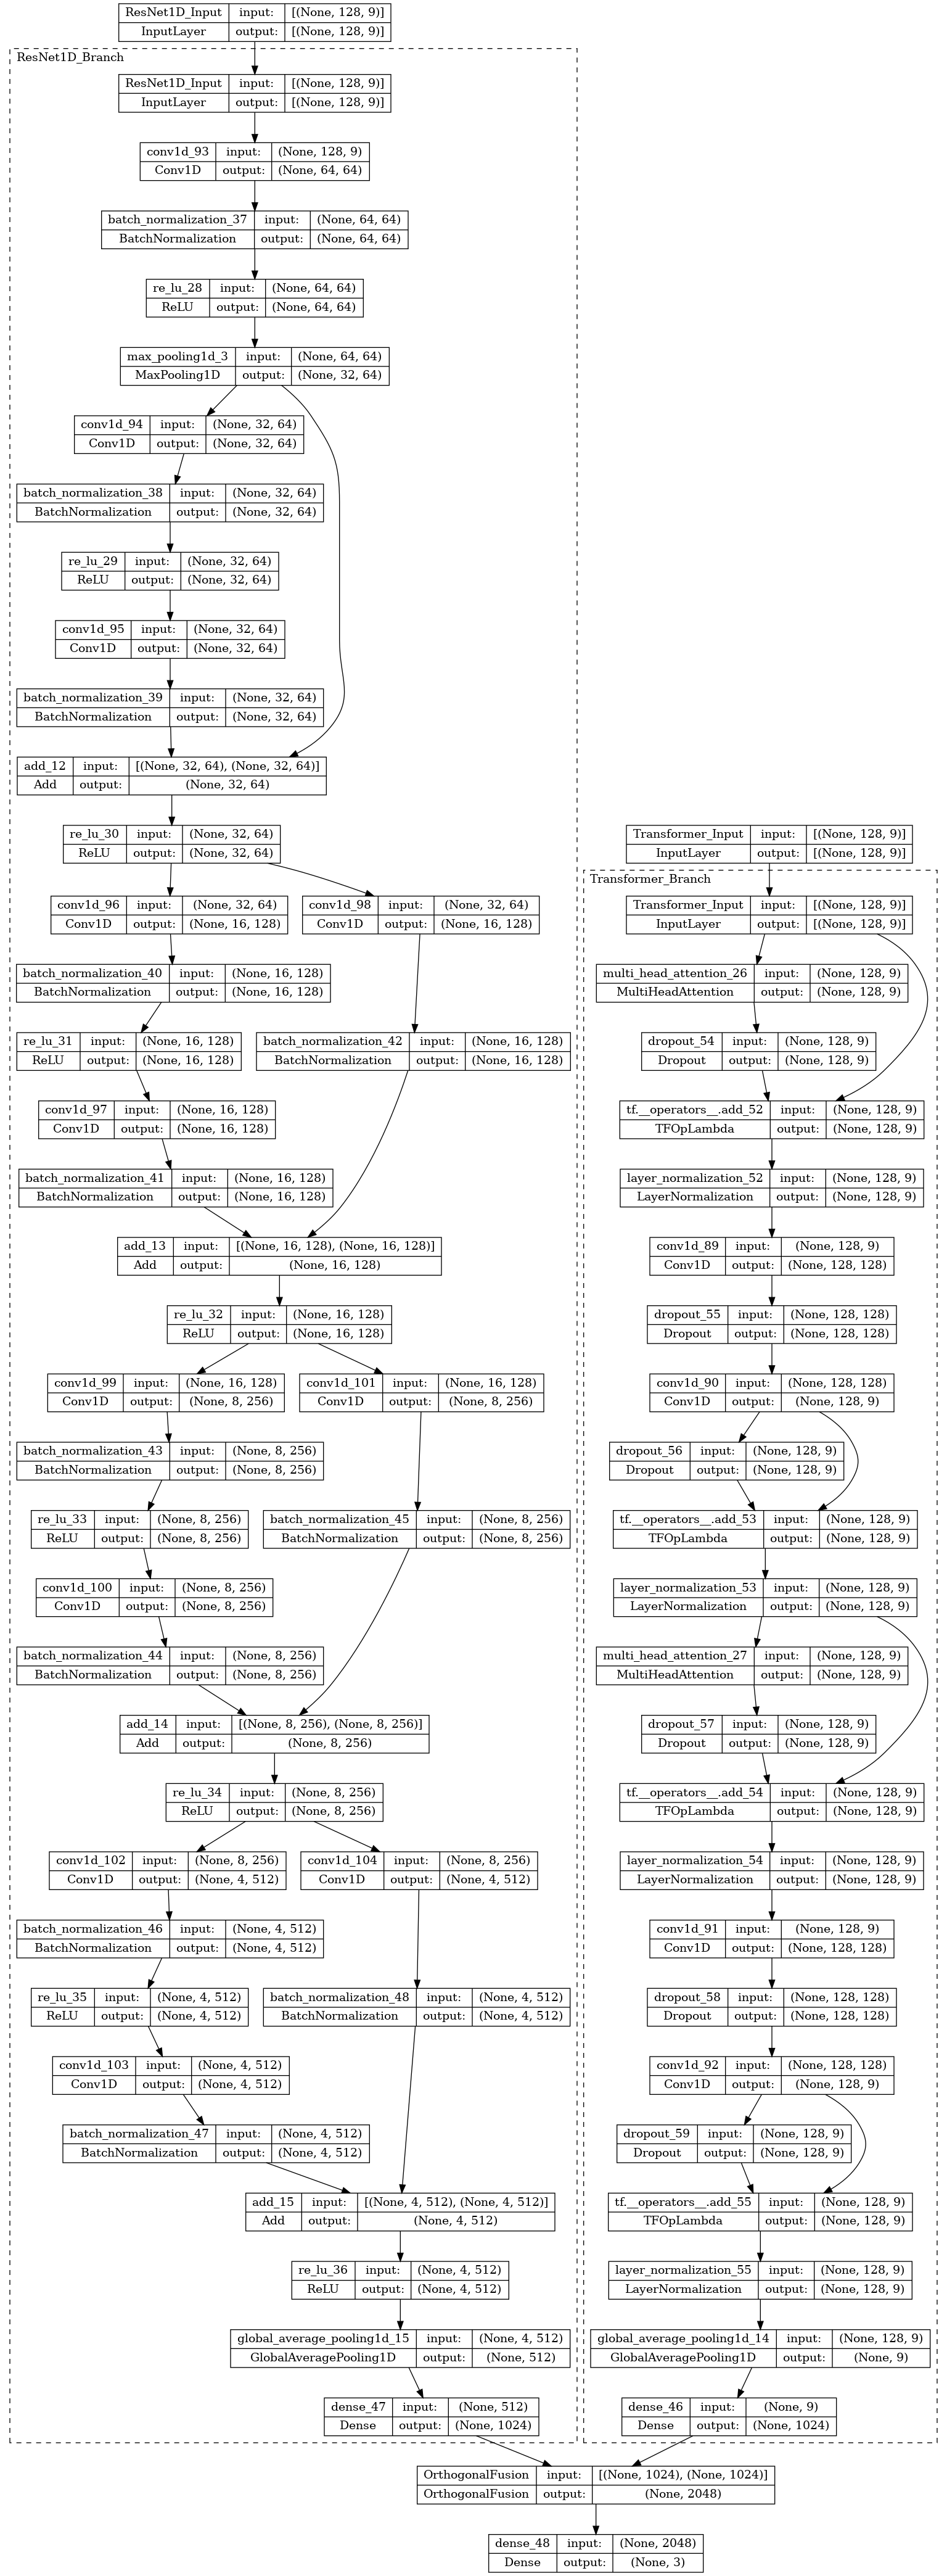

In [80]:
from tensorflow.keras.utils import plot_model

# 모델 시각화
plot_model(
    model,                   # 학습에 사용된 모델
    to_file="model_plot.png",  # 저장할 파일 이름
    show_shapes=True,         # 각 레이어의 출력 텐서 모양 표시
    show_layer_names=True,    # 레이어 이름 표시
    expand_nested=True,       # 중첩된 모델 (서브모델) 시각화
    dpi=96                    # 해상도 설정
)

In [81]:
# 모델 컴파일
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [82]:
# 모델 학습
history = model.fit(
    [train_transformer_input, train_resnet_input], trainy_one_hot,
    validation_data=([test_transformer_input, test_resnet_input], testy_one_hot),
    epochs=50,
    validation_split=0.2,
    batch_size=64
)

Epoch 1/50


2024-12-23 07:54:41.631450: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55b7075adc60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-23 07:54:41.631491: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): CUDA GPU, Compute Capability 8.0
2024-12-23 07:54:41.631499: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): CUDA GPU, Compute Capability 8.0
2024-12-23 07:54:41.636771: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-23 07:54:41.718096: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


64/64 [==============================] - 14s 43ms/step - loss: 0.2782 - accuracy: 0.8820 - val_loss: 0.6793 - val_accuracy: 0.6314
Epoch 2/50
64/64 [==============================] - 2s 26ms/step - loss: 0.2206 - accuracy: 0.9083 - val_loss: 1.0682 - val_accuracy: 0.5256
Epoch 3/50
64/64 [==============================] - 2s 26ms/step - loss: 0.2061 - accuracy: 0.9085 - val_loss: 0.9087 - val_accuracy: 0.3910
Epoch 4/50
64/64 [==============================] - 2s 25ms/step - loss: 0.1945 - accuracy: 0.9142 - val_loss: 0.5859 - val_accuracy: 0.6353
Epoch 5/50
64/64 [==============================] - 2s 25ms/step - loss: 0.1955 - accuracy: 0.9181 - val_loss: 0.6594 - val_accuracy: 0.6532
Epoch 6/50
64/64 [==============================] - 2s 25ms/step - loss: 0.1921 - accuracy: 0.9147 - val_loss: 0.4246 - val_accuracy: 0.8019
Epoch 7/50
64/64 [==============================] - 2s 26ms/step - loss: 0.1794 - accuracy: 0.9206 - val_loss: 0.8794 - val_accuracy: 0.8295
Epoch 8/50
64/64 [=====

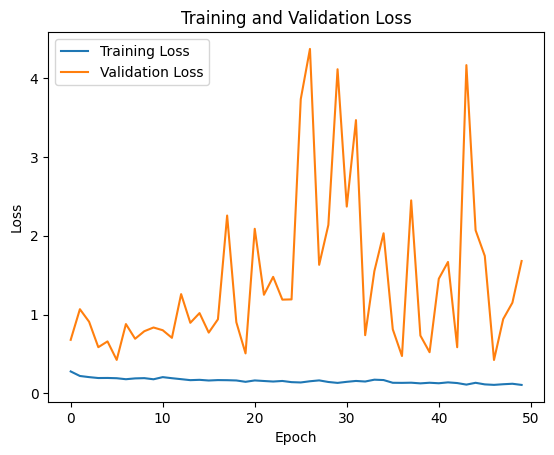

In [83]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

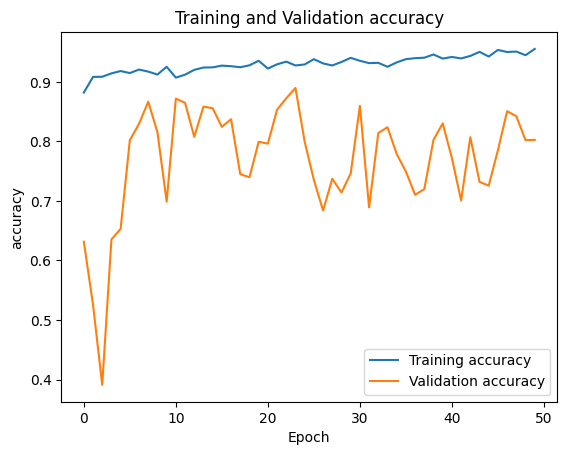

In [87]:
# Plot training and validation loss
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.title('Training and Validation accuracy')
plt.show()

49/49 [==============================] - 0s 4ms/step


(<Figure size 700x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

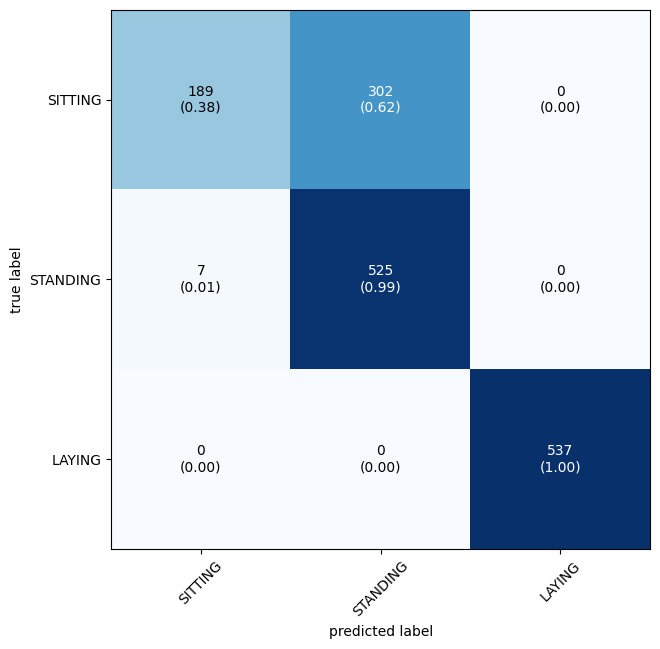

In [88]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import numpy as np

# 예측 수행
predy = model.predict([test_transformer_input, test_resnet_input])

# 예측 결과를 클래스 레이블로 변환
predy = np.argmax(predy, axis=1)

# 실제 레이블을 One-hot에서 숫자 레이블로 변환
truey = np.argmax(testy_one_hot, axis=1)

# 레이블 이름 (static 3개의 레이블만 해당)
LABELS = ['SITTING', 'STANDING', 'LAYING']

# 혼동 행렬 생성
cm = confusion_matrix(truey, predy)

# 혼동 행렬 시각화
plot_confusion_matrix(conf_mat=cm, class_names=LABELS, show_normed=True, figsize=(7,7))


In [89]:
from sklearn.metrics import precision_score, recall_score, f1_score

print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))

[[189 302   0]
 [  7 525   0]
 [  0   0 537]]
0.801923076923077
0.7808940595089703
              precision    recall  f1-score   support

           0       0.96      0.38      0.55       491
           1       0.63      0.99      0.77       532
           2       1.00      1.00      1.00       537

    accuracy                           0.80      1560
   macro avg       0.87      0.79      0.77      1560
weighted avg       0.86      0.80      0.78      1560

